<a href="https://colab.research.google.com/github/dan-a-iancu/airm/blob/master/BlueSky_Simulation/BlueSky_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Booking Limits under Uncertainty at BlueSky Airlines - Asia**

This notebook implements a full solution to the mini-case, assuming you are already familiar with the context

In [ ]:
#@title **Basic Setup.** We start by importing a few useful modules and reading the data in.
#@markdown *Click on the "play" button on the left to run this entire cell.*
import numpy as np
from numpy.random import *

import urllib.request  # for file downloading

# Import pandas for data-frames
import pandas as pd
pd.options.display.max_rows = 15
pd.options.display.float_format = "{:,.2f}".format

# Make sure Matplotlib runs inline, for nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.ticker as ticker 

# Ignore useless some warnings
import warnings
warnings.simplefilter(action="ignore")

print("Completed successfully!")

Completed successfully!


## Load the case data into Pandas data frames and set up any other parameters

We first download an Excel file with all the data from Github.

In [ ]:
#@markdown Download the entire data as an Excel file from Github
url = "https://github.com/dan-a-iancu/airm/blob/master/BlueSky_Simulation/S09-10_AIRM_BlueSky_Simulation_Data.xlsx?raw=true"
local_file = "S09-10_AIRM_BlueSky_Simulation_Data.xlsx"   # name of local file where you want to store the downloaded file
aux = urllib.request.urlretrieve(url, local_file)    # download from website and save it locally

Read in and store the data in suitable dataframes.

In [ ]:
#@markdown Create dataframes based on the Excel file

# Read in all the information about the itinerarys sold, and the aircraft capacities
ItineraryData = pd.read_excel("S09-10_AIRM_BlueSky_Simulation_Data.xlsx", sheet_name = "Data", index_col = 0)
display(ItineraryData)

,SS,FF
Demand_Mean,140,65
Demand_StdDev,55,35
Fare,200,750


**Set up a few additional parameters**

In [ ]:
# Known Data for the problem
Capacity = 200         # plane capacity (# of seats)
BookingLimit_SS = 135   # booking limit for SS class 

<a id='top'></a>
&nbsp;&nbsp;&nbsp;&nbsp;[Q1. A Predictive Model with More Complex Dependencies](#Q1)  
&nbsp;&nbsp;&nbsp;&nbsp;[Q2. Prescriptive Analytics and Optimization](#Q2)  
&nbsp;&nbsp;&nbsp;&nbsp;[Q3. A Simulation Model](#Q3)  
&nbsp;&nbsp;&nbsp;&nbsp;[Q4. Decisions Under Uncertainty](#Q4)  

<a id="Q1"></a>
# **Q1.**

Construct a basic model to predict the revenues under fixed demands. 

*Expand the section for details.*

In [ ]:
# set up the demands equal to the mean of the distribution
Demand_SS = ItineraryData["SS"]["Demand_Mean"]
Demand_FF = ItineraryData["FF"]["Demand_Mean"]

# calculate the (quantity) sales in each category
Sales_SS = min(Demand_SS, BookingLimit_SS, Capacity)
Sales_FF = min(Demand_FF, Capacity - Sales_SS)

# calculate the revenues
Revenues_SS = Sales_SS * ItineraryData["SS"]["Fare"] 
Revenues_FF = Sales_FF * ItineraryData["FF"]["Fare"]
Revenues = Revenues_SS + Revenues_FF

# print the results
print("The revenue when demand = mean is ${:,.0f}".format(Revenues))

The revenue when demand = mean is $75,750


Also create a python function that returns the revenue for a given set of demand values, a given booking limit and a given plane capacity.

In [ ]:
#@markdown Define a function to calculate gross profit given all problem parameters
def calculate_revenues(Demand_SS, Demand_FF, BookingLimit_SS, Capacity):

    # calculate the (quantity) sales in each category
    Sales_SS = min(Demand_SS, BookingLimit_SS, Capacity)
    Sales_FF = min(Demand_FF, Capacity - Sales_SS)

    # calculate the revenues
    Revenues_SS = Sales_SS * ItineraryData["SS"]["Fare"] 
    Revenues_FF = Sales_FF * ItineraryData["FF"]["Fare"]
    Revenues = Revenues_SS + Revenues_FF

    return Revenues

print("Function defined successfully.")

Function defined successfully.


<a id="Q2"></a>
# **Q2.**
We now use the base model from **Q1** and generate samples for the demand values, calculating the revenues in each scenario.

*Expand for details. This section assumes you already ran the section for Q1; if not, please return there and re-run that entire section.*

In [ ]:
#@markdown Set up the number of samples
number_of_samples = 10000 #@param {type:"number"}

# make this an integer, just in case
number_of_samples = np.int(number_of_samples)

# set up a numpy array in which to store the values for the revenues
RevenueValues = np.zeros(number_of_samples)

# set up the seed in the simulation
seed(3112)

# run the simulation:
for t in range(number_of_samples):
    # generate values for the two demands from Normal Distributions
    Demand_SS = np.round(max(0,normal(ItineraryData["SS"]["Demand_Mean"], ItineraryData["SS"]["Demand_StdDev"])))
    Demand_FF = np.round(max(0,normal(ItineraryData["FF"]["Demand_Mean"], ItineraryData["FF"]["Demand_StdDev"])))

    # calculate the (quantity) sales in each category
    Sales_SS = min(Demand_SS, BookingLimit_SS)      # this formula assumes that BookingLimit_SS <= Capacity
    Sales_FF = min(Demand_FF, Capacity - Sales_SS)

    # calculate the revenues
    Revenues_SS = Sales_SS * ItineraryData["SS"]["Fare"] 
    Revenues_FF = Sales_FF * ItineraryData["FF"]["Fare"]
    Revenue = Revenues_SS + Revenues_FF

    # record the value for the revenue
    RevenueValues[t] = Revenue

#@markdown Calculate and print the mean revenue
print("The mean revenue is: ${:,.2f}".format(np.mean(RevenueValues)))

The mean revenue is: $65,046.52


<a id="Q3"></a>
# **Q3.**
We now use the base model from **Q1** and generate samples for the demand values, calculating the revenues as well as determining whether customers are turned away in each scenario/sample.

*Expand for details. This section assumes you already ran the section for Q1; if not, please return there and re-run that entire section.*

In [ ]:
#@markdown Set up the number of samples
number_of_samples = 10000 #@param {type:"number"}

# make this an integer, just in case
number_of_samples = np.int(number_of_samples)

# set up a numpy array in which to store the values for the revenues
RevenueValues = np.zeros(number_of_samples)

# set up a separate numpy array to calculate an indicator for whether an incoming SS customer is turned away
SS_turnedAway = np.zeros(number_of_samples)

# set up the seed in the simulation
seed(3112)

# run the simulation:
for t in range(number_of_samples):
    # generate values for the two demands from Normal Distributions
    Demand_SS = np.round(max(0,normal(ItineraryData["SS"]["Demand_Mean"], ItineraryData["SS"]["Demand_StdDev"])))
    Demand_FF = np.round(max(0,normal(ItineraryData["FF"]["Demand_Mean"], ItineraryData["FF"]["Demand_StdDev"])))

    # calculate the (quantity) sales in each category
    Sales_SS = min(Demand_SS, BookingLimit_SS)      # this formula assumes that BookingLimit_SS <= Capacity
    Sales_FF = min(Demand_FF, Capacity - Sales_SS)

    # calculate the revenues
    Revenues_SS = Sales_SS * ItineraryData["SS"]["Fare"] 
    Revenues_FF = Sales_FF * ItineraryData["FF"]["Fare"]
    Revenue = Revenues_SS + Revenues_FF
    
    # record the value for the revenue
    RevenueValues[t] = Revenue
    
    # determine whether SS customers are turned away
    if Demand_SS > BookingLimit_SS :
        SS_turnedAway[t] = 1
    else:
        SS_turnedAway[t] = 0 # this is for clarity (it's not really needed because the array was initialized with 0)

#@markdown Calculate and print the mean revenue

print("The mean revenue is: ${:,.2f}".format(np.mean(RevenueValues)))

The mean revenue is: $65,046.52


Plot the histogram of revenues.

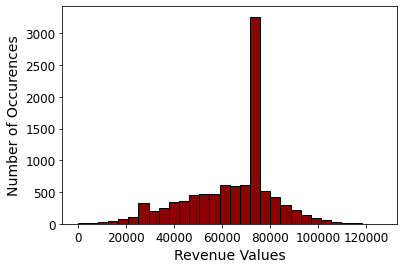

In [ ]:
#@markdown Plot the histogram of revenues
#@markdown - select the number of bins to use
num_bins = 30 #@param {type:"number"}

plt.hist(RevenueValues, bins=num_bins, color="darkred", edgecolor="black")
plt.xlabel("Revenue Values")
plt.ylabel("Number of Occurences")
plt.show()

<a id="Q4"></a>
# **Q4.**
We use the model from **Q3** and test multiple booking limits to determine the one that maximizes the expected revenue.

*Expand for details. This section assumes you already ran the section for Q1; if not, please return there and re-run that entire section.*

<font color=red>__WARNING:__ As written, this loop may take a bit of time to run, because it it testing a lot of values for the booking limit, and running a simulation for every value. If you want to cut down on the running time, a good idea might be to first test booking limit values with larger increments (e.g., from 0 to 200 in increments of 10 or 20), and after identifying the optimal interval you can then run another for loop with a small increment (e.g., assuming the maximum occurs between 140 and 150, you could run a for loop with increments of 1 in this range). </font>

In [ ]:
#@markdown Set up the number of samples
number_of_samples = 10000 #@param {type:"number"}

# make this an integer, just in case
number_of_samples = np.int(number_of_samples)

#@markdown Set up the minimum, maximum, and increment value to test for the booking limit
min_booking_limit = 100  #@param {type:"number"}
max_booking_limit = 200  #@param {type:"number"}
step_size = 5   #@param {type:"number"}

# an array with all the values between min/max in increments of step size
BookingLimitValues = np.arange(min_booking_limit,max_booking_limit+step_size,\
                               step_size)

# set up a numpy array where we will store the value of the mean revenue for each booking limit
MeanRevenueValues = np.zeros(len(BookingLimitValues))

# run a double for loop: the outer one tests multiple booking limit values
for i in range(len(BookingLimitValues)):

    BookingLimit_SS = BookingLimitValues[i]
    
    # set up a numpy array in which to store the values for the revenues
    RevenueValues = np.zeros(number_of_samples)

    # set up the seed in the simulation
    # THIS STEP IS ACTUALLY IMPORTANT HERE, SINCE IT ENSURES WE HAVE A FAIR COMPARISON FOR DIFFERENT BOOKING LIMITS
    seed(110518)
    
    # run the simulation:
    for t in range(number_of_samples):
        # generate values for the two demands from Normal Distributions
        Demand_SS = round(max(0,normal(ItineraryData["SS"]["Demand_Mean"], ItineraryData["SS"]["Demand_StdDev"])))
        Demand_FF = round(max(0,normal(ItineraryData["FF"]["Demand_Mean"], ItineraryData["FF"]["Demand_StdDev"])))

        # calculate the (quantity) sales in each category
        Sales_SS = min(Demand_SS, BookingLimit_SS)      # this formula assumes that BookingLimit_SS <= Capacity
        Sales_FF = min(Demand_FF, Capacity - Sales_SS)

        # calculate the revenues
        Revenues_SS = Sales_SS * ItineraryData["SS"]["Fare"] 
        Revenues_FF = Sales_FF * ItineraryData["FF"]["Fare"]
        Revenue = Revenues_SS + Revenues_FF

        # record the value for the revenue
        RevenueValues[t] = Revenue
        
    MeanRevenueValues[i] = np.mean(RevenueValues)

Determine the optimal booking limit.

In [ ]:
#@markdown Determine the optimal booking limit and revenue
print("The optimal revenue is: {:,.2f}".format(np.max(MeanRevenueValues)))
print("The optimal booking limit is: {:d}".format(BookingLimitValues[np.argmax(MeanRevenueValues)]))

The optimal revenue is: 66,253.30
The optimal booking limit is: 115
